In [9]:
import skimage.io
from matplotlib import pyplot as plt
import cairocffi as cairo
import math, random
import numpy as np
from IPython.display import Image
from scipy.interpolate import interp1d
import astra

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

from skimage.transform import iradon

import seaborn as sns

%matplotlib inline

# Get a point as a pixel location
def point_to_pixel(x, y, w, h):
    xp = int(min(w-1, (x*(w/2) + w/2))) # Avoid going out of bounds
    yp = int(min(h-1, (-y*(h/2) + h/2)))
    return xp, yp

# Floating point version (for interpolation methods later)
def point_to_pixelf(x, y, w, h):
    xp = (min(w-1, (x*(w/2) + w/2))) # Avoid going out of bounds - a little less accurate but hey
    yp = (min(h-1, (-y*(h/2) + h/2)))
    return xp, yp

def draw_des(ds, es, width, height):

    ## Cairo STUFF

    surface = cairo.ImageSurface (cairo.FORMAT_ARGB32, width, height)
    ctx = cairo.Context (surface)

    ctx.set_source_rgb(1,1,1)
    ctx.rectangle(0,0,width,height)
    ctx.fill()

    def circle(ctx, x, y, size):
        ctx.arc(x, y, size, 0, 2 * math.pi)

    ## Back to the good stuff

    # Connect detectors to emitters
    ctx.set_line_width(2)
    ctx.set_source_rgb(0, 0.5, 0)
    for e in es:
        for d in ds:
            ctx.move_to(*point_to_pixel(e['r']*math.cos(e['a']), e['r']*math.sin(e['a']), width, height)) # Wow that's a nifty trick!!
            ctx.line_to(*point_to_pixel(d['r']*math.cos(d['a']), d['r']*math.sin(d['a']), width, height))
    ctx.stroke()

    # Draw detectors
    ctx.set_source_rgb(0, 0, 1)
    for d in ds:
        cx, cy = point_to_pixel(d['r']*math.cos(d['a']), d['r']*math.sin(d['a']), width, height)
        circle(ctx, cx, cy, 20)
        ctx.fill()
        ctx.stroke()
#         print(cx, cy)

    # Draw Emitters
    ctx.set_source_rgb(1, 0, 1)
    for e in es:
        cx, cy = point_to_pixel(e['r']*math.cos(e['a']), e['r']*math.sin(e['a']), width, height)
        circle(ctx, cx, cy, 10)
        ctx.fill()
        ctx.stroke()
#         print(cx, cy)
        
    return surface

def draw_des_surf(surface, ds, es, width, height):
    ctx = cairo.Context (surface)
    def circle(ctx, x, y, size):
        ctx.arc(x, y, size, 0, 2 * math.pi)
    # Connect detectors to emitters
    ctx.set_line_width(2)
    ctx.set_source_rgb(0, 0.5, 0)
    for e in es:
        for d in ds:
            ctx.move_to(*point_to_pixel(e['r']*math.cos(e['a']), e['r']*math.sin(e['a']), width, height)) # Wow that's a nifty trick!!
            ctx.line_to(*point_to_pixel(d['r']*math.cos(d['a']), d['r']*math.sin(d['a']), width, height))
    ctx.stroke()
    # Draw detectors
    ctx.set_source_rgb(0, 0, 1)
    for d in ds:
        cx, cy = point_to_pixel(d['r']*math.cos(d['a']), d['r']*math.sin(d['a']), width, height)
        circle(ctx, cx, cy, 20)
        ctx.fill()
        ctx.stroke()
    # Draw Emitters
    ctx.set_source_rgb(1, 0, 1)
    for e in es:
        cx, cy = point_to_pixel(e['r']*math.cos(e['a']), e['r']*math.sin(e['a']), width, height)
        circle(ctx, cx, cy, 10)
        ctx.fill()
        ctx.stroke()
        
    return surface

def get_paths(img, ds, es, width, height):
    # Does interpolation along all paths from emitters to detectors, given an image, detectors and emitters
    lines = []
    for e in es:
        for d in ds:
            y0, x0 = point_to_pixel(e['r']*math.cos(e['a']), e['r']*math.sin(e['a']), width, height) # E loc
            y1, x1 = point_to_pixel(d['r']*math.cos(d['a']), d['r']*math.sin(d['a']), width, height) # d loc

            # Make samplng points
            length = int(np.hypot(x1-x0, y1-y0))
            x, y = np.linspace(x0, x1, length), np.linspace(y0, y1, length)

            # Extract the values along the line
            zi = img[x.astype(np.int), y.astype(np.int)]
            lines.append(sum(zi))
    return lines

def test_image(w, h, r, x, y):
    surface = cairo.ImageSurface (cairo.FORMAT_ARGB32, w, h)
    ctx = cairo.Context (surface)
    ctx.set_source_rgb(0, 0, 0)
    ctx.rectangle(0,0,w,h)
    ctx.fill()
    xp, yp = point_to_pixel(x, y, w, h)
#     xp -= r
#     yp -= r # Subtract the radius
    ctx.set_source_rgb(1, 1, 1)
    ctx.arc(xp, yp, r, 0, 2 * math.pi)
    ctx.fill()
    ctx.stroke()
    buf  = np.frombuffer(surface.get_data(), np.uint8)
    img = buf.reshape(w, h, 4)[:,:,0]
    return surface, img, x, y

def p1(w, h):
    surface = cairo.ImageSurface (cairo.FORMAT_ARGB32, w, h)
    ctx = cairo.Context (surface)
    ctx.set_source_rgb(0, 0, 0)
    ctx.rectangle(0,0,w,h)
    ctx.fill()
    x, y = 0, 0
    xp, yp = point_to_pixel(x, y, w, h)
#     xp -= r
#     yp -= r # Subtract the radius
    ctx.set_source_rgb(1, 1, 1)
    ctx.rectangle(xp, yp, w/4, h/4)
    ctx.rectangle(xp-w/4, yp-h/4, w/4, h/4)
    ctx.fill()
    ctx.stroke()
    buf  = np.frombuffer(surface.get_data(), np.uint8)
    img = buf.reshape(w, h, 4)[:,:,0]
    return surface, img, x, y

def rotate_des(ds, es, angle):
    for d in ds:
        d['a'] += angle
    for e in es:
        e['a'] += angle
    return ds, es

def r8_des():
    es = []
    ds = []
    for i in range(8):
        d = {
            'r':1, # Distance from center relative to furthest object
            'a':math.pi/2 + math.pi*(i+0.5)/4, #2*math.pi*i/8,
        }
        e = {
            'r':1, # Distance from center relative to furthest object
            'a':math.pi*(i)/4, #2*math.pi*i/8,
        }
        ds.append(d)
        es.append(e)
    return ds, es

# Simulation

We define the position of ds and es in polar coords. For example, here are 8 sensors and 8 emitters drawn from ds and es specified:

Example detector: {'r': 1, 'a': 4.319689898685965}


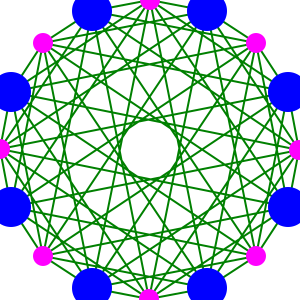

In [13]:
ds, es = r8_des()
s = draw_des(ds, es, 300, 300)
print('Example detector:', ds[3])
s.write_to_png('1.png')
Image('1.png')

We can also use an image to represent the object being scanned. The intensity represents the transmissivity. For example, a fairly opaque disk located at the cartesian coordinates (0.3, 0.5) would look like this:

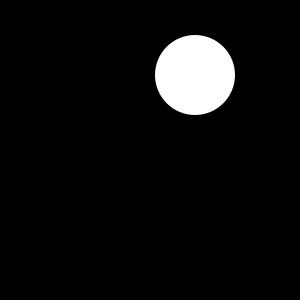

In [29]:
tis, tii, x, y = test_image(300, 300, 40, 0.3, 0.5)
tis.write_to_png('2.png')
Image('2.png')

The simulation traces along all the paths between emitters and detectors, summing the pixels along each. To show this, we'll overlay the two images and print the simulated readings:

Sums along all 64 paths:  [20201, 0, 0, 0, 0, 0, 0, 0, 0, 17786, 20079, 11493, 0, 0, 0, 0, 0, 0, 0, 0, 13642, 20206, 6994, 0, 0, 0, 0, 0, 0, 0, 20207, 0, 0, 0, 0, 0, 0, 0, 10166, 0, 0, 0, 0, 0, 0, 0, 0, 15575, 0, 0, 0, 0, 0, 0, 0, 20233, 0, 0, 0, 0, 0, 0, 0, 16065]


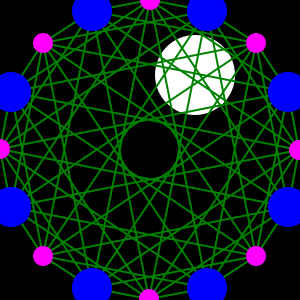

In [34]:
tis, tii, x, y = test_image(300, 300, 40, 0.3, 0.5)
paths = get_paths(tii, ds, es, 300, 300)
print('Sums along all 64 paths: ',paths)
s = draw_des_surf(tis, ds, es, 300, 300)
s.write_to_png('3.png')
Image('3.png')

We can scale these, add noise and account for the angle and distance between the Emitter and Detector like so:

 TODO!

# Reconstruction

Let's see if we can do some image reconstruction based on these readings. 

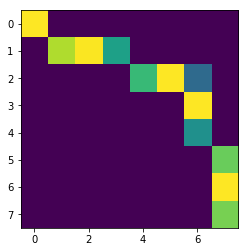

In [36]:
plt.imshow(np.asarray(paths).reshape(8,8))

In [38]:
r2 = []
for e in range(8):
    row = []
    for d in range(8):
        row.append(paths[e*8 + (d+e)%8])
    r2.append(row)

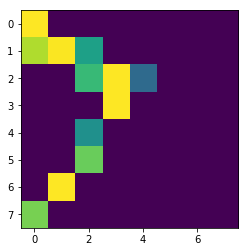

In [39]:
plt.imshow(r2)